In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


# ds = load_dataset("stanfordnlp/imdb")
train_ds = load_dataset("stanfordnlp/imdb", split="train[:100%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:100%]")

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)

    def split_heads(self, x, batch_size):
        return x.view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)

    def forward(self, x, mask):
        batch_size = x.size(0)

        q = self.split_heads(self.wq(x), batch_size)
        k = self.split_heads(self.wk(x), batch_size)
        v = self.split_heads(self.wv(x), batch_size)

        scores = torch.matmul(q, k.transpose(-1, -2)) / sqrt(self.depth)

        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores + (mask * -1e9)

        attn_weights = self.softmax(scores)
        attn_weights = self.dropout(attn_weights)
        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.dense(out)

class TransformerLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        attn_output = self.mha(x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))

        return x


def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[None, ...]

  return torch.FloatTensor(pos_encoding)

max_len = 400
print(positional_encoding(max_len, 256).shape)

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff, dropout=0.1):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)

        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            TransformerLayer(d_model, num_heads=4, dff=dff, dropout=dropout) for _ in range(n_layers)
        ])
        self.classification = nn.Linear(d_model, 1)

    def forward(self, x):
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]

        seq_len = x.shape[1]
        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]
        x = self.classification(x)

        return x

Using cache found in C:\Users\admin/.cache\torch\hub\huggingface_pytorch-transformers_main


torch.Size([1, 400, 256])


# 사용 기법


---



1.   Dropout
2.   Layer Normalization
3.   Residual Connection

# Multi-Head Attention 의 장점


---


하나의 어텐션 헤드는 하나의 관점을 가진다고 볼 수 있다. 따라서 Multi-Head Attention 은 여러 관점(문법적 관점, 의미적 관점 등)에서의 단어간 관계를 이해해, 각 단어의 연관성을 더 풍부하게 파악한다.

또한 각 어텐션 헤드는 병렬 연산이 가능해 높은 성능을 보여준다.


Epoch   0 | Train Loss: 230.8816
=========> Train acc: 0.807 | Test acc: 0.789
Epoch   1 | Train Loss: 168.6585
=========> Train acc: 0.838 | Test acc: 0.805
Epoch   2 | Train Loss: 145.9526
=========> Train acc: 0.875 | Test acc: 0.836
Epoch   3 | Train Loss: 132.9504
=========> Train acc: 0.888 | Test acc: 0.837
Epoch   4 | Train Loss: 122.3504
=========> Train acc: 0.897 | Test acc: 0.838
Epoch   5 | Train Loss: 113.4533
=========> Train acc: 0.917 | Test acc: 0.854
Epoch   6 | Train Loss: 105.6312
=========> Train acc: 0.925 | Test acc: 0.855
Epoch   7 | Train Loss: 98.4891
=========> Train acc: 0.935 | Test acc: 0.855
Epoch   8 | Train Loss: 94.4730
=========> Train acc: 0.943 | Test acc: 0.858
Epoch   9 | Train Loss: 85.5340
=========> Train acc: 0.950 | Test acc: 0.857
Epoch  10 | Train Loss: 80.6535
=========> Train acc: 0.956 | Test acc: 0.858
Epoch  11 | Train Loss: 76.7280
=========> Train acc: 0.959 | Test acc: 0.859
Epoch  12 | Train Loss: 72.7772
=========> Train acc: 0.9

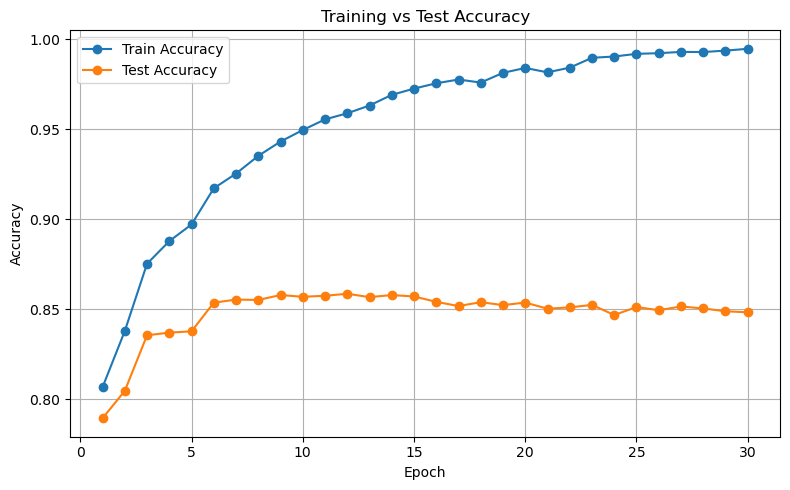

In [ ]:
model = TextClassifier(len(tokenizer), 32, 2, 32)

from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      # preds = torch.argmax(preds, dim=-1)
      preds = (preds > 0).long()[..., 0]

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

  return acc / cnt

train_acc_list = []
test_acc_list = []

n_epochs = 30

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model(inputs)[..., 0]
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss:.4f}")

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")


plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), train_acc_list, label='Train Accuracy', marker='o')
plt.plot(range(1, n_epochs + 1), test_acc_list, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 결과


---

10 epoch 를 전후로 test 정확도가 소폭 감소하는 모습을 보인다. Dropout 에도 불구하고 약간의 과적합이 발생한 것으로 보인다. train 의 경우 100%에 근접한 정확도까지 상승하며, test의 경우 약 85% 로 정확도가 수렴한다.